# **基于深度学习的癌症亚型和扩散预测**

分为3个实验：
- 癌症亚型预测
- 癌症扩散预测
- 癌症亚型和扩散联合预测

## 1、**引入库**

In [28]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchviz import make_dot
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_tensor as image_to_tensor
from sklearn.model_selection import train_test_split

## 2、**数据概览**

### 2.1 **图片数据集概览**：

读取的图片数量:  4385
图片尺寸种类:  1
图片尺寸:  {(80, 80, 3)}

随机展示其中9张图片: 


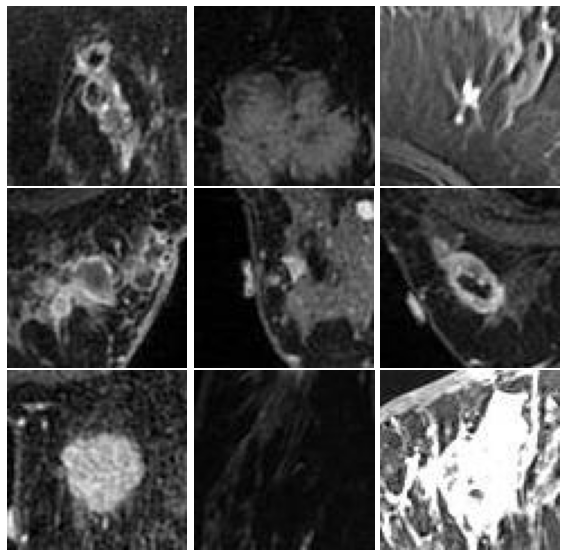

In [4]:
image_dir = r"./trainA"
image_name_list = os.listdir(image_dir)
image_shape_list = []
for image_name in image_name_list:
    path = os.path.join(image_dir, image_name)
    image = cv2.imread(path)
    image_shape_list.append(image.shape)
print("读取的图片数量: ", len(image_shape_list))
image_shape_set = set(image_shape_list)
print("图片尺寸种类: ", len(image_shape_set))
print("图片尺寸: ", image_shape_set)
print("\n随机展示其中9张图片: ")
image = cv2.imread(path)
np.random.shuffle(image_name_list)
plt.subplots(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.01)
for i in range(9):
    image_name = image_name_list[i]
    path = os.path.join(image_dir, image_name)
    image = cv2.imread(path)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

观察图片数据集得到以下结论：图片尺寸一致，均为(H,W,C)=(80,80,3)，后续预处理无需进行resize；图片包含3个channel，为RGB图像，后续建模应当注意；通过可视化，对图片有大致了解。

### 2.2 **Clinical_and_Other_Features.xlsx 文件概览**

In [7]:
data_xlsx = pd.read_excel("./Clinical_and_Other_Features.xlsx", header=None)
print("数据大小：", data_xlsx.shape)

数据大小： (925, 98)


In [8]:
data_xlsx.head()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,Patient Information,MRI Technical Information,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Anti-Her2 Neu Therapy,NaN,Neoadjuvant therapy,Pathologic Response to Neoadjuvant Therapy,NaN,NaN,Near Complete Response,NaN,NaN
1,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Therapeutic or Prophylactic Oophorectomy as pa...,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pa...,Pathologic response to Neoadjuvant therapy: P...,Pathologic response to Neoadjuvant therapy: P...,Overall Near-complete Response: Stricter Defi...,Overall Near-complete Response: Looser Defini...,Near-complete Response (Graded Measure)
2,NaN,NaN,"GE MEDICAL SYSTEMS=0, MPTronic software=1, SIE...","Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIG...","FAST_GEMS\SAT_GEMS\ACC_GEMS\PFP\FS=0,FAST_GEMS...","1.494=0,1.5=1,2.8936=2,3=3","FFP=0,HFP=1",NaN,"GADAVIST=0,MAGNEVIST=1,MMAGNEVIST=2,MULTIHANCE...","6=0,7=1,8=2,9=3,10=4,11=5,11.88=6,12=7,13=8,13...",...,"{0 = no, 1 = yes, NP = not pertinent}","{0 = no, 1 = yes}","{0 = no, 1 = yes}","{1 = yes, 2 = no, NA = not applicable}",{ -1 = TX; 0 = T0; 1 = T1; 2 = T2; 3 = T3;...,{ -1 = NX; 0 = N0; 1 = N1; 2 = N2; 3 = N3...,{ -1 = MX; 0 = M0; 1 = M1; NA = not applica...,"{0 = not complete or near-complete, 1 = comple...","{0 = not complete or near-complete, 1 = comple...",{0 = Not complete or near-complete; 1 = Compl...
3,Breast_MRI_001,6,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,...,1,1,1,1,1,-1,-1,0,0,0
4,Breast_MRI_002,12,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,...,0,0,0,1,NaN,NaN,NaN,2,2,4


观察数据得出以下结论：数据共925行，包含98个属性，前三行均为描述信息，且较为杂乱，在之后的预处理阶段应该将不需要的信息去除

## 3、**数据预处理**

### 3.1 **Clinical_and_Other_Features.xlsx数据处理**

0    893
1     29
Name: metastatic, dtype: int64


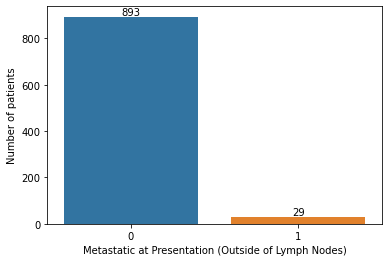

In [9]:
# 读取Excel文件，并将第0行和第2行删去，留下第1行作为columns，删除后为了index的连续性，执行reset_index：
data_xlsx = pd.read_excel("./Clinical_and_Other_Features.xlsx", header=None)
data_xlsx = data_xlsx.drop(labels=[0,2], axis=0)
data_xlsx = data_xlsx.reset_index(drop=True)

# 把此时的第0行的值作为columns，然后把第0行删除，并重新索引：
data_xlsx.columns = data_xlsx.iloc[0, :]
data_xlsx = data_xlsx.drop(labels=[0], axis=0)
data_xlsx = data_xlsx.reset_index(drop=True)

# 把病人ID和是否扩散列重新命名，便于处理，同时只把这两列提取出来，其他列用不到：
data_xlsx.rename(columns={"Patient ID": "p_id", "Metastatic at Presentation (Outside of Lymph Nodes)": "metastatic"}, inplace=True)
data_xlsx = data_xlsx.loc[:, ["p_id", "metastatic"]]
#data_xlsx.loc[:, "p_id"] = data_xlsx.loc[:, "p_id"]

# 将p_id设为索引，便于根据p_id提取数据
data_xlsx = data_xlsx.set_index(["p_id"])

# 打印扩散与否的数量统计信息，并作图展示：
print(data_xlsx.loc[:, "metastatic"].value_counts())
ax = sns.barplot(y=data_xlsx.loc[:, "metastatic"].value_counts().values, x=data_xlsx.loc[:, "metastatic"].value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Metastatic at Presentation (Outside of Lymph Nodes)")
plt.ylabel("Number of patients")
plt.show()

处理该文件的目的是得到病人编号与是否扩散字段的对应关系，进而得到图片与是否扩散的对应关系。
1. 读取Clinical_and_Other_Features.xlsx，删去第一行和第三行的无关描述。
2. 更改"Patient ID"和"Metastatic at Presentation (Outside of Lymph Nodes)"两列的列名分别为"p_id"和"metastatic"，以便于接下来的应用。
3. 删去其他无关列，只保留"p_id"和"metastatic"两列数据，将"p_id"设为索引，得到data_xlsx数据。
4. 统计了"metastatic"字段，共有893个该字段为0的样本，29个该字段为1的样本，无空值和其他脏值。

### 3.2 **图片数据处理**

#### 3.2.1 **图片数据集构建**

对于三个不同实验，需要构建不同的数据集：
- **癌症亚型预测**：每个图片文件的名称中包含了亚型种类编号，将该编号提取作为图片的亚型标签。
- **癌症扩散预测**：上面Excel文件中，"metastatic"列即为扩散的标签。
- **癌症亚型和扩散联合预测**：要求模型能够同时预测亚型和扩散，该问题可看作一个多标签分类问题，为了解决多标签分类问题，将扩散标签和所属亚型标签拼接（字符连接），问题转化为一个多类分类问题。为了支持多类分类问题的求解，生成数据集时应该将图片转化为Array，且标签也应该转化为多分类问题场景下的标签。

In [10]:
image_dir = r"./trainA"
image_name_list = os.listdir(image_dir)
image_list, image_subtype_label_list, image_metastatic_label_list, image_multi_label_list = [], [], [], []
for image_name in image_name_list:
    path = os.path.join(image_dir, image_name)
    split_image_name_list = image_name.split("_")
    subtype = split_image_name_list[1]
    patient_id = split_image_name_list[2]
    patient_id_in_xlsx = "Breast_MRI_" + patient_id
    metastatic = data_xlsx.loc[patient_id_in_xlsx].values[0]
    image_subtype_label_list.append(int(subtype))
    image_metastatic_label_list.append(metastatic)
    image_multi_label_list.append(str(metastatic) + subtype)
    image = cv2.imread(path)
    image_list.append(image)

为了构建数据集，上述过程所做工作如下：
1. 遍历trainA文件夹中的所有图片文件，提取文件名中的亚型编号subtype和病人编号patient_id，"Breast_MRI_"字段和文件名中的编号拼接，即可从data_xlsx中得到其对应的扩散与否标识metastatic，将扩散标识与亚型做字符串拼接，生成多分类任务用到的标签值，image_multi_label_list，例如扩散(1)且亚型为1标签为11；同时将subtype和metastatic分别存入image_subtype_label_list和image_metastatic_label_list
2. 根据遍历到的图片文件路径，读取图片内容，存入image_list。

图像归一化：

In [11]:
np_image_list = np.array(image_list, dtype=np.float32) / 255.0

In [12]:
np_image_list.shape

(4385, 80, 80, 3)

对于癌症亚型和扩散联合预测问题，需要将图片的标签转化为0~7，便于接下来多分类模型损失函数的构建：

In [13]:
scale_mapper = {"00": 0, "01": 1, "02": 2, "03": 3, "10": 4, "11": 5, "12": 6, "13": 7}
image_multi_label_list = pd.Series(image_multi_label_list).replace(scale_mapper).values

便于接下来建模计算，都转化成numpy.array数据类型

In [14]:
image_subtype_label_list = np.array(image_subtype_label_list)
image_metastatic_label_list = np.array(image_metastatic_label_list)

In [15]:
print(image_subtype_label_list)
print(image_metastatic_label_list)
print(image_multi_label_list)

[0 0 0 ... 3 3 3]
[0 0 0 ... 0 0 0]
[0 0 0 ... 3 3 3]


#### 3.2.2 **数据分布**

下面分别查看各个数据集的标签信息，并统计出各个标签值的图片数量

**癌症亚型数据**：

0    2860
3     740
1     485
2     300
dtype: int64


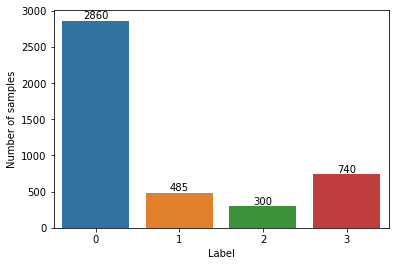

In [16]:
print(pd.Series(image_subtype_label_list).value_counts())
ax = sns.barplot(y=pd.Series(image_subtype_label_list).value_counts().values, x=pd.Series(image_subtype_label_list).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.show()

**癌症扩散数据**：

0    4255
1     130
dtype: int64


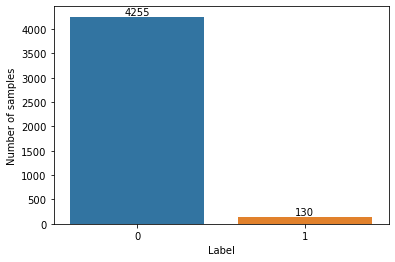

In [17]:
print(pd.Series(image_metastatic_label_list).value_counts())
ax = sns.barplot(y=pd.Series(image_metastatic_label_list).value_counts().values, x=pd.Series(image_metastatic_label_list).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.show()

**癌症亚型和扩散联合数据**：

0    2790
3     725
1     465
2     275
4      70
6      25
5      20
7      15
dtype: int64


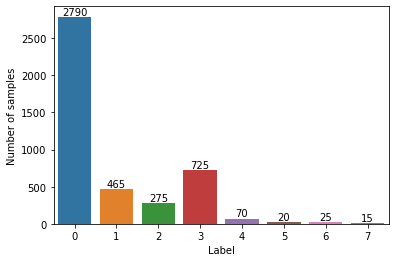

In [18]:
print(pd.Series(image_multi_label_list).value_counts())
ax = sns.barplot(y=pd.Series(image_multi_label_list).value_counts().values, x=pd.Series(image_multi_label_list).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.show()

## 4、**模型构建**

### 4.1 **LeNet模型构建**

In [19]:
class LeNet(nn.Module):
    # 在__init__中定义网络需要的操作算子，比如卷积、全连接算子等等
    def __init__(self, output_size=8):
        super(LeNet, self).__init__()
        # Conv2d的第一个参数是输入的channel数量，第二个是输出的channel数量，第三个是kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 上一层有16个channel输出，每个feature map大小为17*17，所以全连接层的输入是16*17*17
        self.fc1 = nn.Linear(16*17*17, 120)
        self.fc2 = nn.Linear(120, 84)
        
        # 最终有8类，所以最后一个全连接层输出数量是8
        self.fc3 = nn.Linear(84, output_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
    
    # forward定义前向传播
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # 下面这步把二维特征图变为一维，这样全连接层才能处理
        x = x.reshape(-1, 16*17*17)
        x = self.fc1(x)
        x = F.relu(x)
        # 为了避免过拟合，增加dropout层
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### 4.2 **Resnet模型构建**

构建模型Resnet，经实验验证，LeNet效果会好一些：

In [20]:
import torchvision.models as models
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 8)
    def forward(self, x):
        return self.resnet18(x)

### 4.3 **模型展示**

实例化模型，以output_size = 8为例：

In [23]:
# net = Resnet().cuda()
# net = LeNet(output_size = 8).cuda()
net = LeNet(output_size = 8)

#### 4.3.1 **模型组成概览**

输出模型的概要信息，如每层的名称、每层的输出结构以及每层的参数量：

In [25]:
from torchsummary import summary
summary(net, input_size=(3, 80, 80), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 76, 76]             456
         MaxPool2d-2            [-1, 6, 38, 38]               0
            Conv2d-3           [-1, 16, 34, 34]           2,416
         MaxPool2d-4           [-1, 16, 17, 17]               0
            Linear-5                  [-1, 120]         555,000
           Dropout-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
            Linear-8                    [-1, 8]             680
Total params: 568,716
Trainable params: 568,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 0.51
Params size (MB): 2.17
Estimated Total Size (MB): 2.75
----------------------------------------------------------------


#### 4.3.2 **模型可视化**

In [30]:
# x = Variable(torch.randn(1,3,80,80))
# make_dot(net(x), params=dict(net.named_parameters()))

## 5、**模型训练和评估**

### 5.1 **癌症亚型预测模型**

#### 5.1.1 **数据集划分**

将4385张图片按照4:1的比例，划分为训练集和测试集，然后从测试集中按照4:1的比例划分为最终对的测试集和验证集：

In [31]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_subtype_label_list, test_size=0.2, random_state = 42) 
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [32]:
print("训练集大小：", x_train.shape)
print("验证集大小：",x_validation.shape)
print("测试集大小：",x_test.shape)

训练集大小： (3508, 80, 80, 3)
验证集大小： (176, 80, 80, 3)
测试集大小： (701, 80, 80, 3)


查看训练集中各类数据的数量，并可视化展示：

0    2265
3     593
1     402
2     248
dtype: int64


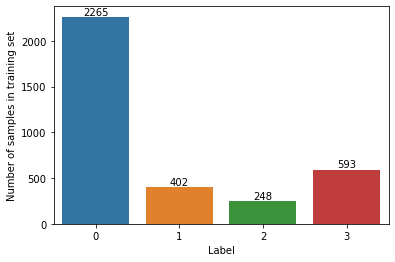

In [33]:
print(pd.Series(y_train).value_counts())
ax = sns.barplot(y=pd.Series(y_train).value_counts().values, x=pd.Series(y_train).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in training set")
plt.show()

查看验证集中各类数据的数量，并可视化展示：

0    124
3     31
1     11
2     10
dtype: int64


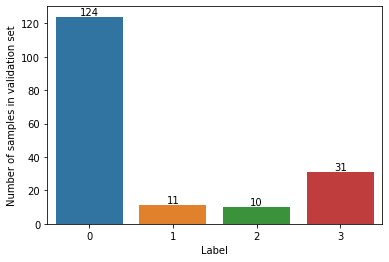

In [34]:
print(pd.Series(y_validation).value_counts())
ax = sns.barplot(y=pd.Series(y_validation).value_counts().values, x=pd.Series(y_validation).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in validation set")
plt.show()

查看测试集中各类数据的数量，并可视化展示：

0    471
3    116
1     72
2     42
dtype: int64


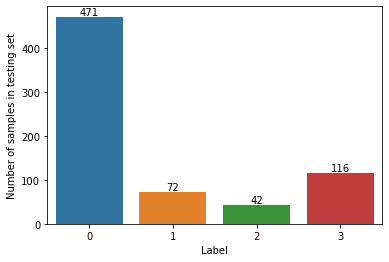

In [35]:
print(pd.Series(y_test).value_counts())
ax = sns.barplot(y=pd.Series(y_test).value_counts().values, x=pd.Series(y_test).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in testing set")
plt.show()

#### 5.1.2 **数据加载器定义**

In [36]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        if self.mode=="train":
            self.x_train = x_train
            self.y_train = y_train
        elif self.mode=="test":
            self.x_test = x_test
            self.y_test = y_test
        else:
            self.x_validation = x_validation
            self.y_validation = y_validation

    def __getitem__(self, index):
        if self.mode=="train":
            return self.x_train[index], self.y_train[index]
        elif self.mode=="test":
            return self.x_test[index], self.y_test[index]
        else:
            return self.x_validation[index], self.y_validation[index]

    def __len__(self):
        if self.mode=="train":
            return self.x_train.shape[0]
        elif self.mode=="test":
            return self.x_test.shape[0]
        else:
            return self.x_validation.shape[0]

定义数据集加载时的batch_size，并分别实例化train_loader、test_loader和validation_loader：

In [37]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataset = MyDataset(mode="train")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(mode="test")
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = MyDataset(mode="validation")
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

#### 5.1.3 **损失函数和优化器定义**

In [39]:
# optim中定义了各种各样的优化方法，包括SGD
import torch.optim as optim
net = LeNet(output_size = 4)
# CrossEntropyLoss就是我们需要的损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 5.1.4 **模型训练**

val函数用于验证模型在给定数据集上的表现。输入：模型、数据加载器；输出：模型在数据上的平均loss和accuracy

In [44]:
def val(net, data_loader):
    correct = 0
    total_sample = 0
    loss_all = 0.0
    # net.eval()使网络层权重值固定，用于模型测试
    net.eval()
    # 使用torch.no_grad,在前向传播中不记录梯度，节省内存
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.permute(0,3,1,2)
            images = images
            labels = labels.type(torch.LongTensor)
            labels = labels
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_all += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_sample += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss_all/total_sample, correct/total_sample

模型训练，一共训练EPOCH轮，每一轮测试模型在训练集和验证集上的表现

In [45]:
print("Start Training...")
EPOCH = 80
train_loss_list = []  # 存储每个epoch的训练损失
train_accuracy_list = []  # 存储每个epoch的训练accuracy
val_loss_list = []  # 存储每个epoch的验证集损失
val_accuracy_list = []  # 存储每个epoch的验证集accuracy
for epoch in range(EPOCH):
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.permute(0,3,1,2)
        labels = labels.type(torch.LongTensor)
        labels = labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_accuracy = val(net, train_loader)
    val_loss, val_accuracy = val(net, validation_loader)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    print('[Epoch %3d] training loss: %.6f training accuracy: %.6f validation loss: %.6f validation accuracy: %.6f'%(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

print("Done Training!")

Start Training...
[Epoch   1] training loss: 0.063938 training accuracy: 0.645667 validation loss: 0.057436 validation accuracy: 0.704545
[Epoch   2] training loss: 0.063646 training accuracy: 0.645667 validation loss: 0.057373 validation accuracy: 0.704545
[Epoch   3] training loss: 0.063262 training accuracy: 0.645667 validation loss: 0.056797 validation accuracy: 0.704545
[Epoch   4] training loss: 0.062875 training accuracy: 0.645667 validation loss: 0.056286 validation accuracy: 0.704545
[Epoch   5] training loss: 0.062958 training accuracy: 0.645667 validation loss: 0.056827 validation accuracy: 0.704545
[Epoch   6] training loss: 0.062425 training accuracy: 0.645667 validation loss: 0.055569 validation accuracy: 0.704545
[Epoch   7] training loss: 0.062084 training accuracy: 0.645667 validation loss: 0.056127 validation accuracy: 0.704545
[Epoch   8] training loss: 0.062083 training accuracy: 0.645667 validation loss: 0.055124 validation accuracy: 0.704545
[Epoch   9] training l

[Epoch  70] training loss: 0.000052 training accuracy: 1.000000 validation loss: 0.017594 validation accuracy: 0.948864
[Epoch  71] training loss: 0.000026 training accuracy: 1.000000 validation loss: 0.016244 validation accuracy: 0.954545
[Epoch  72] training loss: 0.000078 training accuracy: 0.999715 validation loss: 0.017352 validation accuracy: 0.943182
[Epoch  73] training loss: 0.000053 training accuracy: 1.000000 validation loss: 0.016542 validation accuracy: 0.948864
[Epoch  74] training loss: 0.000060 training accuracy: 1.000000 validation loss: 0.019029 validation accuracy: 0.948864
[Epoch  75] training loss: 0.000024 training accuracy: 1.000000 validation loss: 0.012494 validation accuracy: 0.954545
[Epoch  76] training loss: 0.000069 training accuracy: 1.000000 validation loss: 0.021120 validation accuracy: 0.948864
[Epoch  77] training loss: 0.000049 training accuracy: 1.000000 validation loss: 0.020770 validation accuracy: 0.943182
[Epoch  78] training loss: 0.000290 trai

#### 5.1.5 **模型训练和验证结果分析**

画出训练集和验证集的准确率及loss曲线：

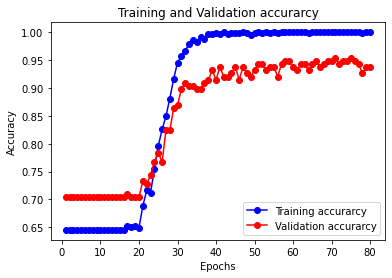

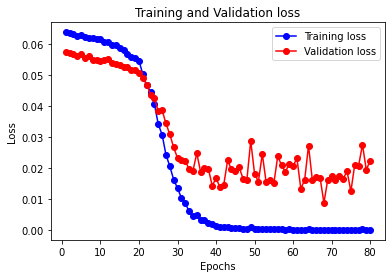

In [46]:
epochs = range(1, len(train_accuracy_list) + 1)

#绘制每个epoch训练集和验证集的精度
plt.plot(epochs, train_accuracy_list, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_accuracy_list, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#绘制每个epoch训练集和验证集的损失
plt.plot(epochs, train_loss_list, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_list, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

画出训练集的准确率曲线：

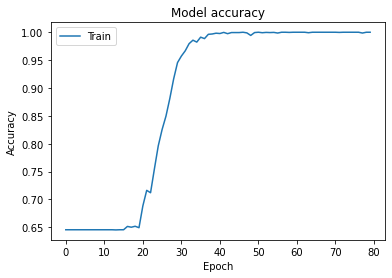

In [47]:
# 绘制训练集上模型的accuracy曲线
plt.plot(train_accuracy_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

画出训练集的loss曲线：

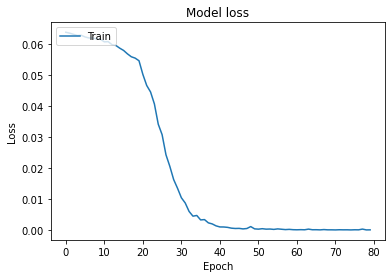

In [48]:
# 绘制训练集上模型的loss曲线
plt.plot(train_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 5.1.6 **模型测试结果分析**

使用预留出来的最终测试集test_dataset，对模型进行验证：

**计算accuracy**：

In [49]:
correct = 0
total = 0
pre_label = []
true_label = []
all_outputs = torch.tensor([])
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.permute(0,3,1,2)
        images = images
        labels = labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_outputs = torch.cat([all_outputs, outputs.detach().cpu()], axis=0)
        pre_label.extend(predicted.detach().cpu().numpy().tolist())
        true_label.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
all_outputs = all_outputs.numpy()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 95 %


**模型保存**：

In [50]:
torch.save(net, 'model_subtype_prediction.pth')

**混淆矩阵**：

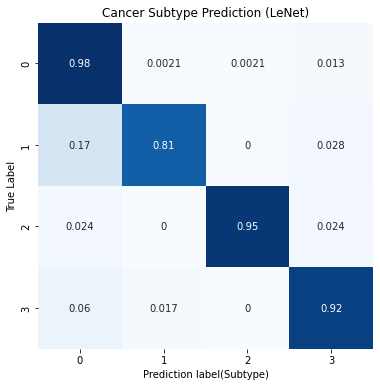

In [51]:
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label,pre_label)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label = ['0','1', '2','3']
label = np.array(label)

cm_df = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Blues',cbar=False)
plt.title('Cancer Subtype Prediction (LeNet)')
plt.ylabel('True Label')
plt.xlabel('Prediction label(Subtype)')
plt.show()

**Roc曲线**：

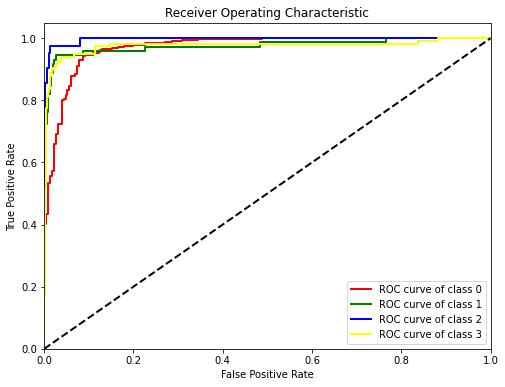

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
plt.rcParams["figure.figsize"] = [8,6]

fpr = dict()
tpr = dict()
roc_auc = dict()

onehot_encoder = OneHotEncoder(sparse=False)
true_label = np.array(true_label)
true_label = true_label.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(true_label)

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(onehot_encoded[:,i], all_outputs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'black'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0}'''.format(label[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

### 5.2 **癌症扩散预测模型**

#### 5.2.1 **数据集划分**

将4385张图片按照4:1的比例，划分为训练集和测试集，然后从测试集中按照4:1的比例划分为最终对的测试集和验证集：

In [89]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_metastatic_label_list, test_size=0.2, random_state = 42) 
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [90]:
print("训练集大小：", x_train.shape)
print("验证集大小：",x_validation.shape)
print("测试集大小：",x_test.shape)

训练集大小： (3508, 80, 80, 3)
验证集大小： (176, 80, 80, 3)
测试集大小： (701, 80, 80, 3)


查看训练集中各类数据的数量，并可视化展示：

0    3405
1     103
dtype: int64


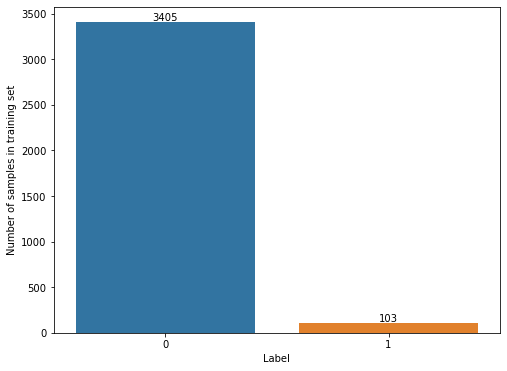

In [91]:
print(pd.Series(y_train).value_counts())
ax = sns.barplot(y=pd.Series(y_train).value_counts().values, x=pd.Series(y_train).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in training set")
plt.show()

查看验证集中各类数据的数量，并可视化展示：

0    170
1      6
dtype: int64


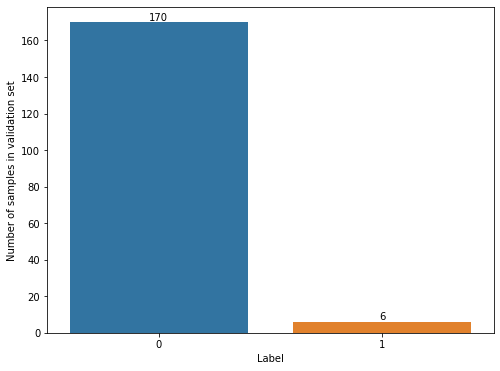

In [92]:
print(pd.Series(y_validation).value_counts())
ax = sns.barplot(y=pd.Series(y_validation).value_counts().values, x=pd.Series(y_validation).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in validation set")
plt.show()

查看测试集中各类数据的数量，并可视化展示：

0    680
1     21
dtype: int64


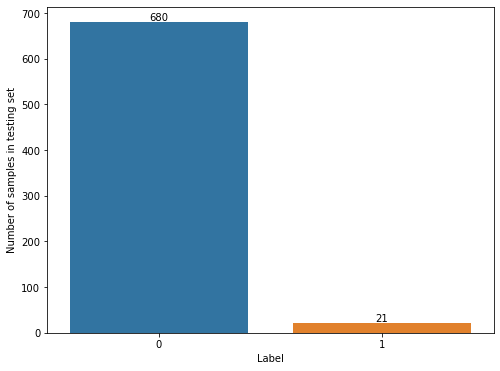

In [93]:
print(pd.Series(y_test).value_counts())
ax = sns.barplot(y=pd.Series(y_test).value_counts().values, x=pd.Series(y_test).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in testing set")
plt.show()

#### 5.2.2 **数据加载器定义**

In [94]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        if self.mode=="train":
            self.x_train = x_train
            self.y_train = y_train
        elif self.mode=="test":
            self.x_test = x_test
            self.y_test = y_test
        else:
            self.x_validation = x_validation
            self.y_validation = y_validation

    def __getitem__(self, index):
        if self.mode=="train":
            return self.x_train[index], self.y_train[index]
        elif self.mode=="test":
            return self.x_test[index], self.y_test[index]
        else:
            return self.x_validation[index], self.y_validation[index]

    def __len__(self):
        if self.mode=="train":
            return self.x_train.shape[0]
        elif self.mode=="test":
            return self.x_test.shape[0]
        else:
            return self.x_validation.shape[0]

定义数据集加载时的batch_size，并分别实例化train_loader、test_loader和validation_loader：

In [95]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataset = MyDataset(mode="train")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(mode="test")
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = MyDataset(mode="validation")
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

#### 5.2.3 **损失函数和优化器定义**

In [96]:
# optim中定义了各种各样的优化方法，包括SGD
import torch.optim as optim
net = LeNet(output_size = 2)
# CrossEntropyLoss就是我们需要的损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 5.2.4 **模型训练**

val函数用于验证模型在给定数据集上的表现。输入：模型、数据加载器；输出：模型在数据上的平均loss和accuracy

In [97]:
def val(net, data_loader):
    correct = 0
    total_sample = 0
    loss_all = 0.0
    # net.eval()使网络层权重值固定，用于模型测试
    net.eval()
    # 使用torch.no_grad,在前向传播中不记录梯度，节省内存
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.permute(0,3,1,2)
            images = images
            labels = labels.type(torch.LongTensor)
            labels = labels
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_all += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_sample += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss_all/total_sample, correct/total_sample

模型训练，一共训练EPOCH轮，每一轮测试模型在训练集和验证集上的表现

In [98]:
print("Start Training...")
EPOCH = 100  # 可以自由调整这个Epoch数量
train_loss_list = []  # 存储每个epoch的训练损失
train_accuracy_list = []  # 存储每个epoch的训练accuracy
val_loss_list = []  # 存储每个epoch的验证集损失
val_accuracy_list = []  # 存储每个epoch的验证集accuracy
for epoch in range(EPOCH):
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.permute(0,3,1,2)
        labels = labels.type(torch.LongTensor)
        labels = labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_accuracy = val(net, train_loader)
    val_loss, val_accuracy = val(net, validation_loader)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    print('[Epoch %3d] training loss: %.6f training accuracy: %.6f validation loss: %.6f validation accuracy: %.6f'%(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

print("Done Training!")

Start Training...
[Epoch   1] training loss: 0.009485 training accuracy: 0.970639 validation loss: 0.011177 validation accuracy: 0.965909
[Epoch   2] training loss: 0.009137 training accuracy: 0.970639 validation loss: 0.010778 validation accuracy: 0.965909
[Epoch   3] training loss: 0.008664 training accuracy: 0.970639 validation loss: 0.010031 validation accuracy: 0.965909
[Epoch   4] training loss: 0.008631 training accuracy: 0.970639 validation loss: 0.009523 validation accuracy: 0.965909
[Epoch   5] training loss: 0.008240 training accuracy: 0.970639 validation loss: 0.009130 validation accuracy: 0.965909
[Epoch   6] training loss: 0.008243 training accuracy: 0.970639 validation loss: 0.009288 validation accuracy: 0.965909
[Epoch   7] training loss: 0.008540 training accuracy: 0.970639 validation loss: 0.009342 validation accuracy: 0.965909
[Epoch   8] training loss: 0.008086 training accuracy: 0.970639 validation loss: 0.009075 validation accuracy: 0.965909
[Epoch   9] training l

[Epoch  70] training loss: 0.000803 training accuracy: 0.997149 validation loss: 0.002145 validation accuracy: 0.988636
[Epoch  71] training loss: 0.000830 training accuracy: 0.996864 validation loss: 0.001939 validation accuracy: 0.988636
[Epoch  72] training loss: 0.000772 training accuracy: 0.998005 validation loss: 0.001319 validation accuracy: 0.994318
[Epoch  73] training loss: 0.000501 training accuracy: 0.998005 validation loss: 0.001753 validation accuracy: 0.988636
[Epoch  74] training loss: 0.000496 training accuracy: 0.998290 validation loss: 0.001356 validation accuracy: 0.988636
[Epoch  75] training loss: 0.000429 training accuracy: 0.998575 validation loss: 0.001169 validation accuracy: 0.994318
[Epoch  76] training loss: 0.000330 training accuracy: 0.998575 validation loss: 0.002424 validation accuracy: 0.988636
[Epoch  77] training loss: 0.000273 training accuracy: 0.998575 validation loss: 0.002168 validation accuracy: 0.994318
[Epoch  78] training loss: 0.000314 trai

#### 5.2.5 **模型训练和验证结果分析**

画出训练集和验证集的准确率及loss曲线：

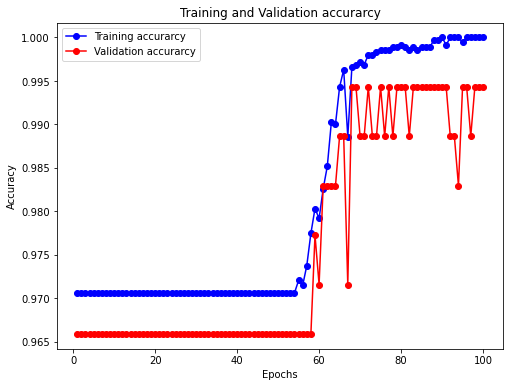

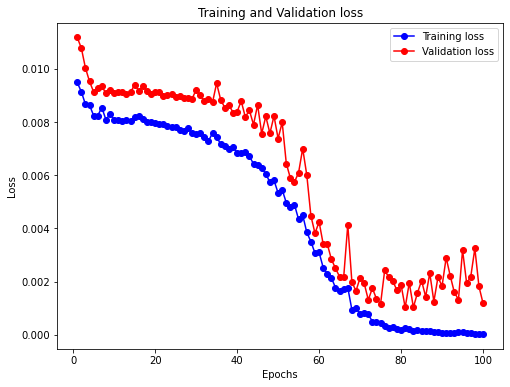

In [99]:
epochs = range(1, len(train_accuracy_list) + 1)

#绘制每个epoch训练集和验证集的精度
plt.plot(epochs, train_accuracy_list, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_accuracy_list, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#绘制每个epoch训练集和验证集的损失
plt.plot(epochs, train_loss_list, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_list, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

画出训练集的准确率曲线：

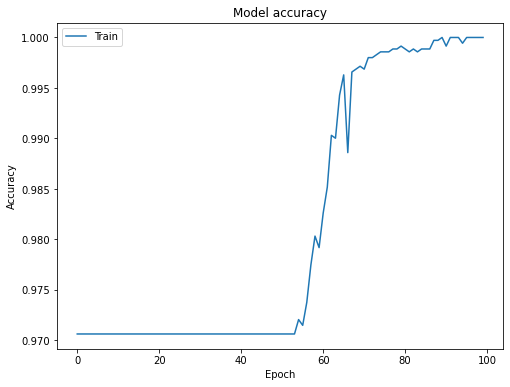

In [100]:
# 绘制训练集上模型的accuracy曲线
plt.plot(train_accuracy_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

画出训练集的loss曲线：

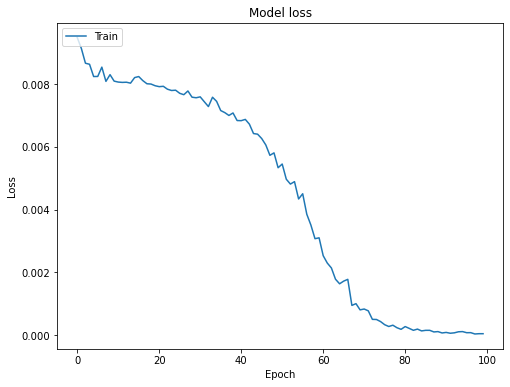

In [101]:
# 绘制训练集上模型的loss曲线
plt.plot(train_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 5.2.6 **模型测试结果分析**

使用预留出来的最终测试集test_dataset，对模型进行验证：

**计算accuracy**：

In [102]:
correct = 0
total = 0
pre_label = []
true_label = []
all_outputs = torch.tensor([])
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.permute(0,3,1,2)
        images = images
        labels = labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_outputs = torch.cat([all_outputs, outputs.detach().cpu()], axis=0)
        pre_label.extend(predicted.detach().cpu().numpy().tolist())
        true_label.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
all_outputs = all_outputs.numpy()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 99 %


**模型保存**：

In [103]:
torch.save(net, 'model_metastasis_prediction.pth')

**混淆矩阵**：

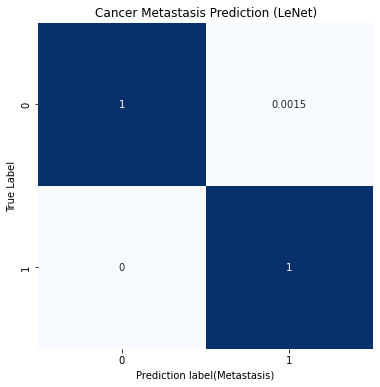

In [104]:
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label,pre_label)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label = ['0','1']
label = np.array(label)

cm_df = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Blues',cbar=False)
plt.title('Cancer Metastasis Prediction (LeNet)')
plt.ylabel('True Label')
plt.xlabel('Prediction label(Metastasis)')
plt.show()

**Roc曲线**：

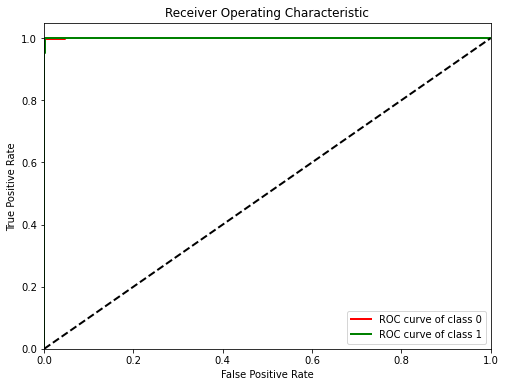

In [105]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
plt.rcParams["figure.figsize"] = [8,6]

fpr = dict()
tpr = dict()
roc_auc = dict()

onehot_encoder = OneHotEncoder(sparse=False)
true_label = np.array(true_label)
true_label = true_label.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(true_label)

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(onehot_encoded[:,i], all_outputs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'black'])
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0}'''.format(label[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

### 5.3 **癌症亚型和扩散联合预测模型**

#### 5.3.1 **数据集划分**

将4385张图片按照4:1的比例，划分为训练集和测试集，然后从测试集中按照4:1的比例划分为最终对的测试集和验证集：

In [106]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_multi_label_list, test_size=0.2, random_state = 42) 
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [107]:
print("训练集大小：", x_train.shape)
print("验证集大小：",x_validation.shape)
print("测试集大小：",x_test.shape)

训练集大小： (3508, 80, 80, 3)
验证集大小： (176, 80, 80, 3)
测试集大小： (701, 80, 80, 3)


查看训练集中各类数据的数量，并可视化展示：

0    2212
3     581
1     386
2     226
4      53
6      22
5      16
7      12
dtype: int64


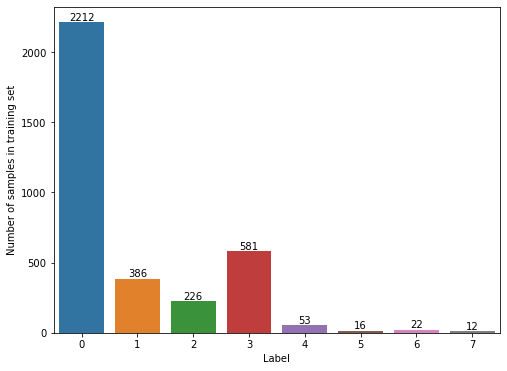

In [108]:
print(pd.Series(y_train).value_counts())
ax = sns.barplot(y=pd.Series(y_train).value_counts().values, x=pd.Series(y_train).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in training set")
plt.show()

查看验证集中各类数据的数量，并可视化展示：

0    120
3     31
1     10
2      9
4      4
6      1
5      1
dtype: int64


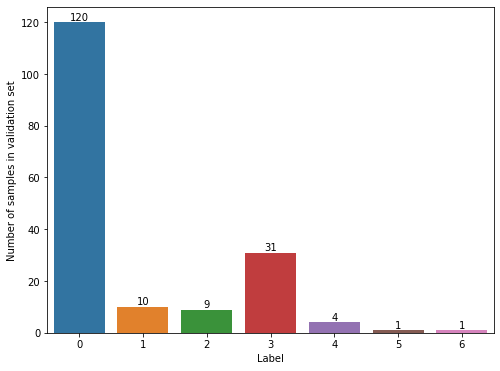

In [109]:
print(pd.Series(y_validation).value_counts())
ax = sns.barplot(y=pd.Series(y_validation).value_counts().values, x=pd.Series(y_validation).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in validation set")
plt.show()

查看测试集中各类数据的数量，并可视化展示：

0    458
3    113
1     69
2     40
4     13
5      3
7      3
6      2
dtype: int64


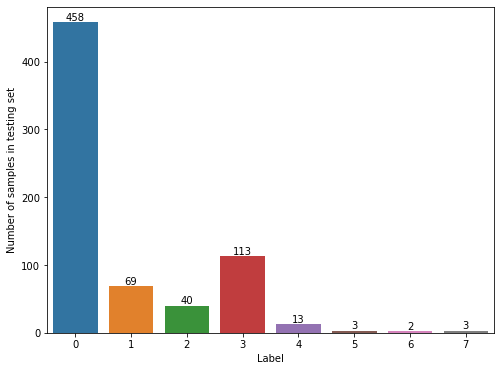

In [110]:
print(pd.Series(y_test).value_counts())
ax = sns.barplot(y=pd.Series(y_test).value_counts().values, x=pd.Series(y_test).value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
plt.xlabel("Label")
plt.ylabel("Number of samples in testing set")
plt.show()

#### 5.3.2 **数据加载器定义**

In [111]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, mode="train"):
        self.mode = mode
        if self.mode=="train":
            self.x_train = x_train
            self.y_train = y_train
        elif self.mode=="test":
            self.x_test = x_test
            self.y_test = y_test
        else:
            self.x_validation = x_validation
            self.y_validation = y_validation

    def __getitem__(self, index):
        if self.mode=="train":
            return self.x_train[index], self.y_train[index]
        elif self.mode=="test":
            return self.x_test[index], self.y_test[index]
        else:
            return self.x_validation[index], self.y_validation[index]

    def __len__(self):
        if self.mode=="train":
            return self.x_train.shape[0]
        elif self.mode=="test":
            return self.x_test.shape[0]
        else:
            return self.x_validation.shape[0]

定义数据集加载时的batch_size，并分别实例化train_loader、test_loader和validation_loader：

In [112]:
from torch.utils.data import DataLoader
batch_size = 16
train_dataset = MyDataset(mode="train")
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(mode="test")
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
validation_dataset = MyDataset(mode="validation")
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

#### 5.3.3 **损失函数和优化器定义**

In [113]:
# optim中定义了各种各样的优化方法，包括SGD
import torch.optim as optim
net = LeNet(output_size = 8)
# CrossEntropyLoss就是我们需要的损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 5.3.4 **模型训练**

val函数用于验证模型在给定数据集上的表现。输入：模型、数据加载器；输出：模型在数据上的平均loss和accuracy

In [114]:
def val(net, data_loader):
    correct = 0
    total_sample = 0
    loss_all = 0.0
    # net.eval()使网络层权重值固定，用于模型测试
    net.eval()
    # 使用torch.no_grad,在前向传播中不记录梯度，节省内存
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images = images.permute(0,3,1,2)
            images = images
            labels = labels.type(torch.LongTensor)
            labels = labels
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss_all += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_sample += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss_all/total_sample, correct/total_sample

模型训练，一共训练EPOCH轮，每一轮测试模型在训练集和验证集上的表现

In [115]:
print("Start Training...")
EPOCH = 100
train_loss_list = []  # 存储每个epoch的训练损失
train_accuracy_list = []  # 存储每个epoch的训练accuracy
val_loss_list = []  # 存储每个epoch的验证集损失
val_accuracy_list = []  # 存储每个epoch的验证集accuracy
for epoch in range(EPOCH):
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.permute(0,3,1,2)
        labels = labels.type(torch.LongTensor)
        labels = labels
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss, train_accuracy = val(net, train_loader)
    val_loss, val_accuracy = val(net, validation_loader)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    print('[Epoch %3d] training loss: %.6f training accuracy: %.6f validation loss: %.6f validation accuracy: %.6f'%(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))

print("Done Training!")

Start Training...
[Epoch   1] training loss: 0.075546 training accuracy: 0.630559 validation loss: 0.070422 validation accuracy: 0.681818
[Epoch   2] training loss: 0.073292 training accuracy: 0.630559 validation loss: 0.067748 validation accuracy: 0.681818
[Epoch   3] training loss: 0.071523 training accuracy: 0.630559 validation loss: 0.065446 validation accuracy: 0.681818
[Epoch   4] training loss: 0.071286 training accuracy: 0.630559 validation loss: 0.065073 validation accuracy: 0.681818
[Epoch   5] training loss: 0.071138 training accuracy: 0.630559 validation loss: 0.065191 validation accuracy: 0.681818
[Epoch   6] training loss: 0.071020 training accuracy: 0.630559 validation loss: 0.064866 validation accuracy: 0.681818
[Epoch   7] training loss: 0.071079 training accuracy: 0.630559 validation loss: 0.065181 validation accuracy: 0.681818
[Epoch   8] training loss: 0.070678 training accuracy: 0.630559 validation loss: 0.064731 validation accuracy: 0.681818
[Epoch   9] training l

[Epoch  70] training loss: 0.000191 training accuracy: 0.999715 validation loss: 0.010344 validation accuracy: 0.948864
[Epoch  71] training loss: 0.000185 training accuracy: 1.000000 validation loss: 0.010877 validation accuracy: 0.937500
[Epoch  72] training loss: 0.000234 training accuracy: 1.000000 validation loss: 0.016144 validation accuracy: 0.937500
[Epoch  73] training loss: 0.000221 training accuracy: 1.000000 validation loss: 0.008937 validation accuracy: 0.943182
[Epoch  74] training loss: 0.000194 training accuracy: 0.999715 validation loss: 0.016097 validation accuracy: 0.948864
[Epoch  75] training loss: 0.000175 training accuracy: 1.000000 validation loss: 0.013797 validation accuracy: 0.931818
[Epoch  76] training loss: 0.000260 training accuracy: 0.999715 validation loss: 0.012542 validation accuracy: 0.948864
[Epoch  77] training loss: 0.000204 training accuracy: 1.000000 validation loss: 0.010628 validation accuracy: 0.960227
[Epoch  78] training loss: 0.000255 trai

#### 5.3.5 **模型训练和验证结果分析**

画出训练集和验证集的准确率及loss曲线：

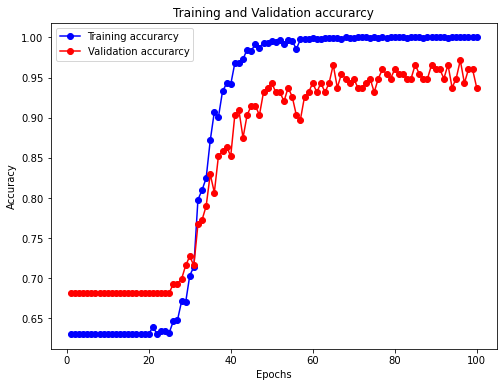

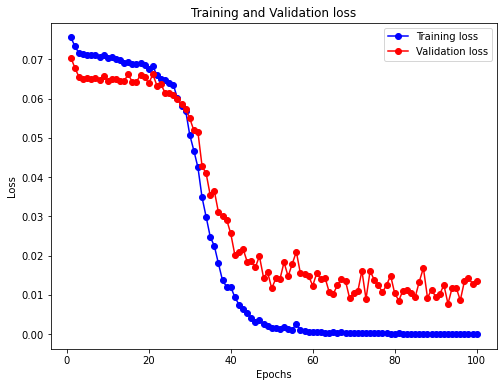

In [116]:
epochs = range(1, len(train_accuracy_list) + 1)

#绘制每个epoch训练集和验证集的精度
plt.plot(epochs, train_accuracy_list, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_accuracy_list, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

#绘制每个epoch训练集和验证集的损失
plt.plot(epochs, train_loss_list, 'b-o', label='Training loss')
plt.plot(epochs, val_loss_list, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

画出训练集的准确率曲线：

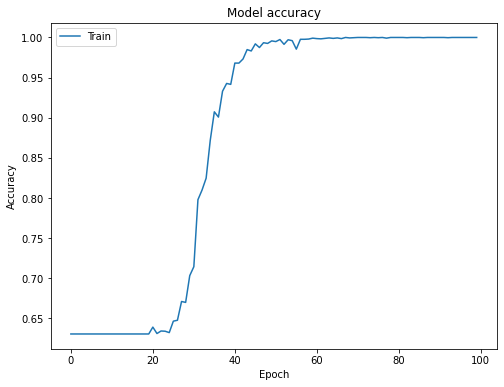

In [117]:
# 绘制训练集上模型的accuracy曲线
plt.plot(train_accuracy_list)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

画出训练集的loss曲线：

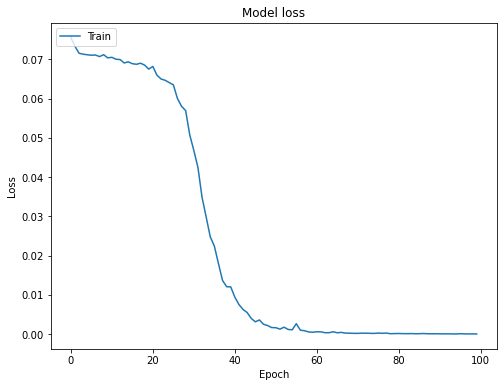

In [118]:
# 绘制训练集上模型的loss曲线
plt.plot(train_loss_list)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### 5.3.6 **模型测试结果分析**

使用预留出来的最终测试集test_dataset，对模型进行验证：

**计算accuracy**：

In [119]:
correct = 0
total = 0
pre_label = []
true_label = []
all_outputs = torch.tensor([])
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.permute(0,3,1,2)
        images = images
        labels = labels
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_outputs = torch.cat([all_outputs, outputs.detach().cpu()], axis=0)
        pre_label.extend(predicted.detach().cpu().numpy().tolist())
        true_label.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
all_outputs = all_outputs.numpy()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 95 %


**模型保存**：

In [120]:
torch.save(net, 'model_multi_prediction.pth')

**混淆矩阵**：

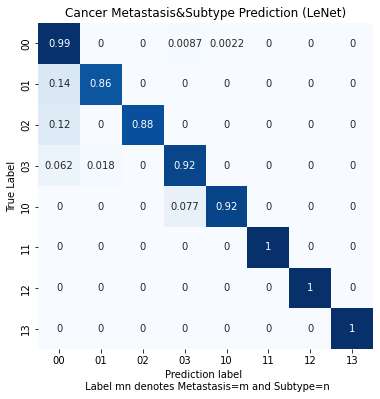

In [121]:
#Creating a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label,pre_label)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

label = ['00','01', '02','03','10','11', '12','13',]
label = np.array(label)

cm_df = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (6,6))
sns.heatmap(cm_df, annot = True,cmap='Blues',cbar=False)
plt.title('Cancer Metastasis&Subtype Prediction (LeNet)')
plt.ylabel('True Label')
plt.xlabel('Prediction label \n Label mn denotes Metastasis=m and Subtype=n')
plt.show()

**Roc曲线**：

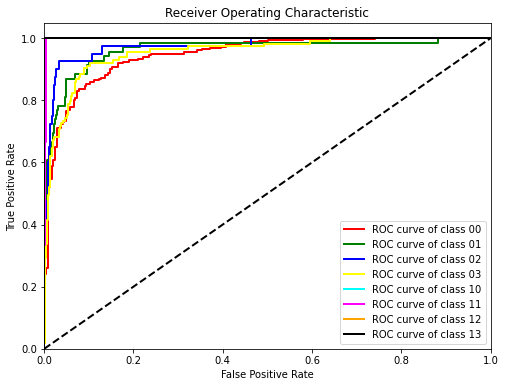

In [122]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from itertools import cycle
plt.rcParams["figure.figsize"] = [8,6]

fpr = dict()
tpr = dict()
roc_auc = dict()

onehot_encoder = OneHotEncoder(sparse=False)
true_label = np.array(true_label)
true_label = true_label.reshape(-1, 1)
onehot_encoded = onehot_encoder.fit_transform(true_label)

for i in range(8):
    fpr[i], tpr[i], _ = roc_curve(onehot_encoded[:,i], all_outputs[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'black'])
for i, color in zip(range(8), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0}'''.format(label[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()

## 6、**运行环境**：

In [123]:
import numpy
print("numpy=="+ numpy.__version__)
import pandas
print("pandas=="+ pandas.__version__)
import matplotlib
print("matplotlib=="+ matplotlib.__version__)
import seaborn
print("seaborn=="+ seaborn.__version__)
import scipy
print("scipy=="+ scipy.__version__)
import sklearn
print("sklearn=="+ sklearn.__version__)
import cv2
print("opencv-python=="+cv2.__version__)
import platform 
print("python:"+platform.python_version())

numpy==1.19.5
pandas==1.3.4
matplotlib==3.4.3
seaborn==0.11.2
scipy==1.7.1
sklearn==0.24.2
opencv-python==4.6.0
python:3.9.7
